In [1]:
%pip install rdkit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 54.2 MB/s eta 0:00:00


Step 1: PGM Model
PGM - R^2: 0.83, MSE: 0.29, Accuracy: 0.70


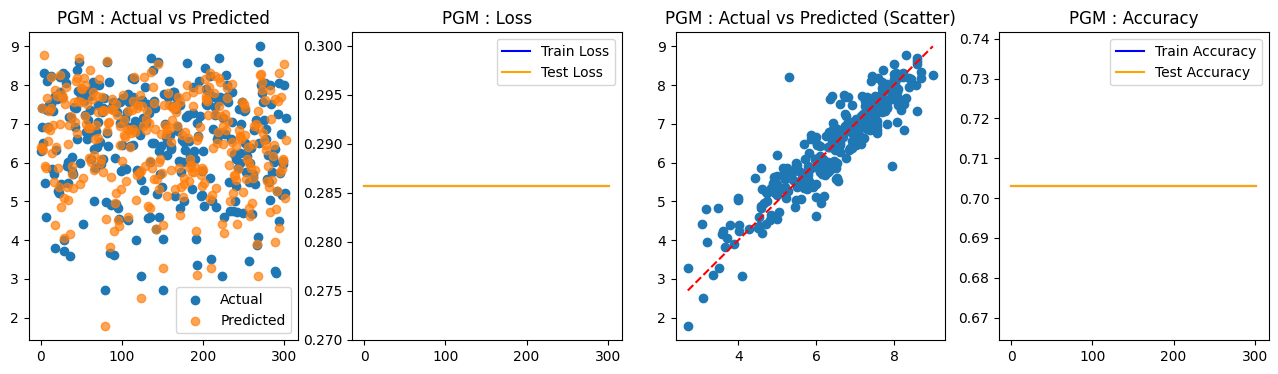

Step 2: GNN Model
Epoch 100/500, Loss: 0.5320, Accuracy: 0.5512
Epoch 200/500, Loss: 0.2007, Accuracy: 0.7793
Epoch 300/500, Loss: 0.1053, Accuracy: 0.8983
Epoch 400/500, Loss: 0.0674, Accuracy: 0.9388
Epoch 500/500, Loss: 0.0489, Accuracy: 0.9661
GNN - R^2: 0.83, MSE: 0.29, Accuracy: 0.78


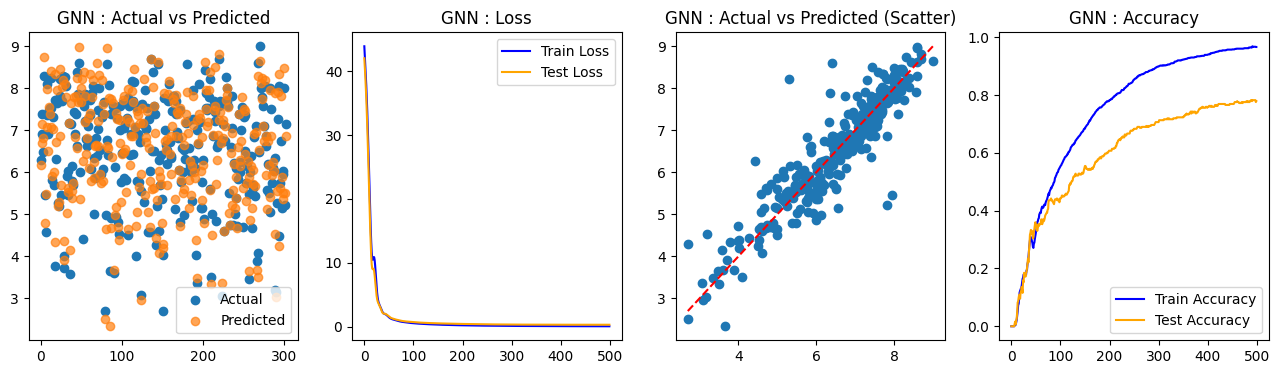

Step 3: PGM + GNN Model
Epoch 100/500, Combined Loss: 0.3863, Accuracy: 0.6364
Epoch 200/500, Combined Loss: 0.1557, Accuracy: 0.8289
Epoch 300/500, Combined Loss: 0.0977, Accuracy: 0.9017
Epoch 400/500, Combined Loss: 0.0712, Accuracy: 0.9380
Epoch 500/500, Combined Loss: 0.0548, Accuracy: 0.9603


In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Load BACE data
data = pd.read_csv('bace.csv')  # Replace with the actual path to your CSV file
data.columns = data.columns.str.strip()  # Clean any spaces in column names

# Data preprocessing
X = data.drop(columns=['pIC50', 'CID', 'mol', 'Class', 'Model'], errors='ignore')  # Adjust columns according to your data
y = data['pIC50']

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Set accuracy threshold for regression
accuracy_threshold = 0.5

# Function to plot performance
def plot_results(model_name, y_test, preds, train_losses, test_losses, train_accuracies, test_accuracies, title_suffix=""):
    plt.figure(figsize=(16, 4))

    # Actual vs Predicted
    plt.subplot(1, 4, 1)
    plt.scatter(range(len(y_test)), y_test, label="Actual")
    plt.scatter(range(len(y_test)), preds, label="Predicted", alpha=0.7)
    plt.title(f"{model_name} {title_suffix}: Actual vs Predicted")
    plt.legend()

    # Loss Graph (train vs test)
    plt.subplot(1, 4, 2)
    plt.plot(train_losses, label="Train Loss", color='blue')
    plt.plot(test_losses, label="Test Loss", color='orange')
    plt.title(f"{model_name} {title_suffix}: Loss")
    plt.legend()

    # Actual vs Predicted Scatter
    plt.subplot(1, 4, 3)
    plt.scatter(y_test, preds)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.title(f"{model_name} {title_suffix}: Actual vs Predicted (Scatter)")

    # Accuracy Graph (train vs test)
    plt.subplot(1, 4, 4)
    plt.plot(train_accuracies, label="Train Accuracy", color='blue')
    plt.plot(test_accuracies, label="Test Accuracy", color='orange')
    plt.title(f"{model_name} {title_suffix}: Accuracy")
    plt.legend()

    plt.show()

### Step 1: PGM Model ###
print("Step 1: PGM Model")
pgm_model = BayesianRidge()
pgm_model.fit(X_train, y_train)
pgm_preds = pgm_model.predict(X_test)

# Evaluate PGM model performance
pgm_r2 = r2_score(y_test, pgm_preds)
pgm_mse = mean_squared_error(y_test, pgm_preds)
pgm_accuracy = np.mean(np.abs(pgm_preds - y_test) < accuracy_threshold)  # Accuracy based on a threshold
print(f"PGM - R^2: {pgm_r2:.2f}, MSE: {pgm_mse:.2f}, Accuracy: {pgm_accuracy:.2f}")

# Plot results for PGM
plot_results("PGM", y_test, pgm_preds, [pgm_mse] * len(y_test), [pgm_mse] * len(y_test), [pgm_accuracy] * len(y_test), [pgm_accuracy] * len(y_test))

### Step 2: GNN Model ###
print("Step 2: GNN Model")

# Define the GNN model
class GNN(nn.Module):
    def __init__(self, input_dim):
        super(GNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Convert data to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Initialize the GNN model
gnn_model = GNN(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)

# Train the GNN model
epochs = 500
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    gnn_model.train()
    optimizer.zero_grad()
    predictions = gnn_model(X_train_t)
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Calculate accuracy during training
    train_accuracy = np.mean(np.abs(predictions.detach().numpy().flatten() - y_train_t.numpy().flatten()) < accuracy_threshold)
    train_accuracies.append(train_accuracy)

    # Calculate accuracy and loss on the test dataset
    gnn_model.eval()
    with torch.no_grad():
        test_preds = gnn_model(X_test_t)
        test_loss = criterion(test_preds, y_test_t)
        test_accuracy = np.mean(np.abs(test_preds.detach().numpy().flatten() - y_test_t.numpy().flatten()) < accuracy_threshold)

    test_losses.append(test_loss.item())
    test_accuracies.append(test_accuracy)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}")

# Evaluate the GNN model
gnn_model.eval()
gnn_preds = gnn_model(X_test_t).detach().numpy().flatten()
gnn_r2 = r2_score(y_test, gnn_preds)
gnn_mse = mean_squared_error(y_test, gnn_preds)
gnn_accuracy = np.mean(np.abs(gnn_preds - y_test) < accuracy_threshold)
print(f"GNN - R^2: {gnn_r2:.2f}, MSE: {gnn_mse:.2f}, Accuracy: {gnn_accuracy:.2f}")

# Plot results for GNN
plot_results("GNN", y_test, gnn_preds, train_losses, test_losses, train_accuracies, test_accuracies)

### Step 3: PGM+GNN Model (Combination) ###
print("Step 3: PGM + GNN Model")

# Use the PGM model predictions as additional input features for the GNN
pgm_preds_train = pgm_model.predict(X_train)
pgm_preds_test = pgm_model.predict(X_test)

# Add PGM predictions as a new feature
X_train_combined = np.column_stack([X_train, pgm_preds_train])
X_test_combined = np.column_stack([X_test, pgm_preds_test])

# Convert to PyTorch tensors
X_train_combined_t = torch.tensor(X_train_combined, dtype=torch.float32)
X_test_combined_t = torch.tensor(X_test_combined, dtype=torch.float32)

# Define a combined GNN model
gnn_combined_model = GNN(input_dim=X_train_combined.shape[1])
optimizer = torch.optim.Adam(gnn_combined_model.parameters(), lr=0.001)

# Train the combined model
combined_train_losses = []
combined_test_losses = []
combined_train_accuracies = []
combined_test_accuracies = []

for epoch in range(epochs):
    gnn_combined_model.train()
    optimizer.zero_grad()
    predictions = gnn_combined_model(X_train_combined_t)
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    combined_train_losses.append(loss.item())

    # Calculate accuracy during training
    train_accuracy = np.mean(np.abs(predictions.detach().numpy().flatten() - y_train_t.numpy().flatten()) < accuracy_threshold)
    combined_train_accuracies.append(train_accuracy)

    # Calculate accuracy and loss on the test dataset
    gnn_combined_model.eval()
    with torch.no_grad():
        test_preds = gnn_combined_model(X_test_combined_t)
        test_loss = criterion(test_preds, y_test_t)
        test_accuracy = np.mean(np.abs(test_preds.detach().numpy().flatten() - y_test_t.numpy().flatten()) < accuracy_threshold)

    combined_test_losses.append(test_loss.item())
    combined_test_accuracies.append(test_accuracy)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Combined Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}")

# Evaluate the combined model
gnn_combined_model.eval()
gnn_combined_preds = gnn_combined_model(X_test_combined_t).detach().numpy().flatten()
gnn_combined_r2 = r2_score(y_test, gnn_combined_preds)
gnn_combined_mse = mean_squared_error(y_test, gnn_combined_preds)



=== 95% Bootstrap CIs on Test Set ===
     Model  R2_mean   R2_lo   R2_hi  MSE_mean  MSE_lo  MSE_hi  ACC_mean  \
0      GNN   0.8286  0.7626  0.8811    0.2904  0.2014  0.3972    0.7793   
1  GNN+PGM   0.8610  0.8013  0.9065    0.2348  0.1646  0.3215    0.8282   
2      PGM   0.8317  0.7788  0.8735    0.2856  0.2228  0.3694    0.7036   

   ACC_lo  ACC_hi  
0  0.7327  0.8284  
1  0.7855  0.8713  
2  0.6535  0.7558  


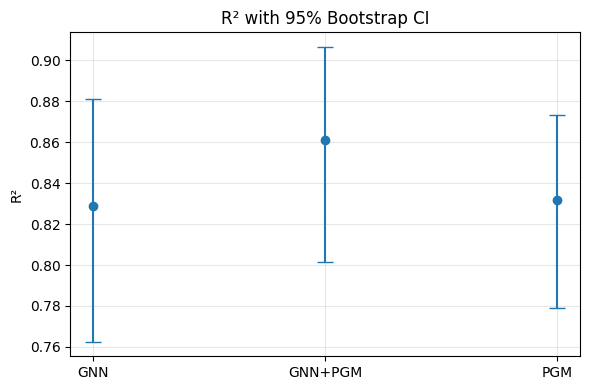

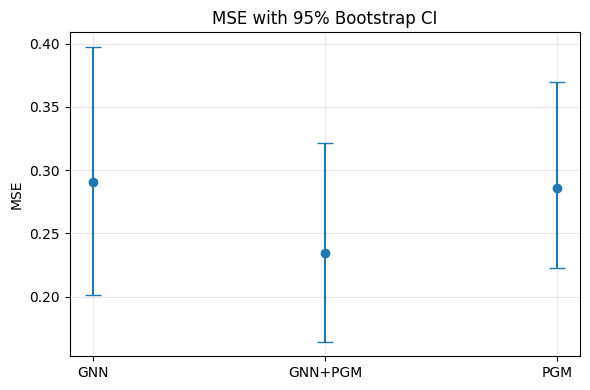

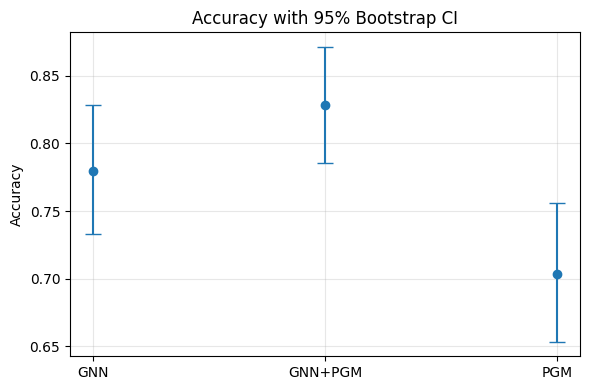

In [22]:
# ==== 95% CIs (bootstrap on test set) + Error-bar plots per metric ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# Reuse: y_test (Series), accuracy_threshold (float),
# and predictions: pgm_preds, gnn_preds, gnn_combined_preds

rng = np.random.default_rng(42)

y_true = np.asarray(y_test, dtype=float)
preds_dict = {
    "PGM": np.asarray(pgm_preds, dtype=float).flatten(),
    "GNN": np.asarray(gnn_preds, dtype=float).flatten(),
    "GNN+PGM": np.asarray(gnn_combined_preds, dtype=float).flatten(),
}

def acc_within(y, p, thr):
    return np.mean(np.abs(p - y) < thr)

def r2_safe(y, p):
    # Avoid undefined R² if y is (near) constant in a bootstrap resample
    if np.allclose(y, y.mean()):
        return 0.0
    return r2_score(y, p)

def bootstrap_metric(y, p, metric_fn, n_boot=2000, rng=None):
    """Percentile bootstrap 95% CI for a scalar metric on paired data."""
    n = len(y)
    idx = np.arange(n)
    stats = np.empty(n_boot, dtype=float)
    for b in range(n_boot):
        res = rng.choice(idx, size=n, replace=True)
        stats[b] = metric_fn(y[res], p[res])
    stats.sort()
    lo = np.percentile(stats, 2.5)
    hi = np.percentile(stats, 97.5)
    mean = float(stats.mean())
    return mean, lo, hi

rows = []
for name, p in preds_dict.items():
    r2_mean, r2_lo, r2_hi = bootstrap_metric(y_true, p, r2_safe, n_boot=2000, rng=rng)
    mse_mean, mse_lo, mse_hi = bootstrap_metric(y_true, p, mean_squared_error, n_boot=2000, rng=rng)
    acc_mean, acc_lo, acc_hi = bootstrap_metric(
        y_true, p, lambda y, q: acc_within(y, q, accuracy_threshold), n_boot=2000, rng=rng
    )
    rows.append({
        "Model": name,
        "R2_mean": r2_mean, "R2_lo": r2_lo, "R2_hi": r2_hi,
        "MSE_mean": mse_mean, "MSE_lo": mse_lo, "MSE_hi": mse_hi,
        "ACC_mean": acc_mean, "ACC_lo": acc_lo, "ACC_hi": acc_hi,
    })

summary_df = pd.DataFrame(rows).sort_values("Model").reset_index(drop=True)
print("\n=== 95% Bootstrap CIs on Test Set ===")
print(summary_df[[
    "Model",
    "R2_mean","R2_lo","R2_hi",
    "MSE_mean","MSE_lo","MSE_hi",
    "ACC_mean","ACC_lo","ACC_hi"
]].round(4))

# --- Error-bar plots (asymmetric) ---
def errorbar_plot(metric, ylabel, title):
    labels = summary_df["Model"].values
    means = summary_df[f"{metric}_mean"].values
    los   = summary_df[f"{metric}_lo"].values
    his   = summary_df[f"{metric}_hi"].values
    yerr  = np.vstack([means - los, his - means])  # asymmetric
    x = np.arange(len(labels))
    plt.figure(figsize=(6,4))
    plt.errorbar(x, means, yerr=yerr, fmt='o', capsize=6)
    plt.xticks(x, labels)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

errorbar_plot("R2",  "R²",  "R² with 95% Bootstrap CI")
errorbar_plot("MSE", "MSE", "MSE with 95% Bootstrap CI")
errorbar_plot("ACC", f'Accuracy', "Accuracy with 95% Bootstrap CI")
# ==== End CI block ====


Step 1: PGM Model
PGM - R^2: 0.72, MSE: 0.48, Accuracy: 0.65


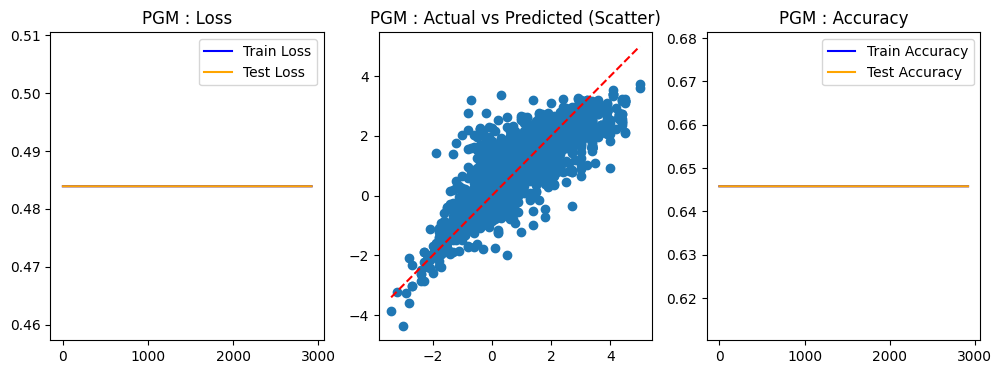

Step 2: GNN Model
Epoch 100/500, Loss: 0.3833, Accuracy: 0.7087
Epoch 200/500, Loss: 0.3445, Accuracy: 0.7234
Epoch 300/500, Loss: 0.3214, Accuracy: 0.7362
Epoch 400/500, Loss: 0.3072, Accuracy: 0.7446
Epoch 500/500, Loss: 0.2972, Accuracy: 0.7514
GNN - R^2: 0.81, MSE: 0.32, Accuracy: 0.74


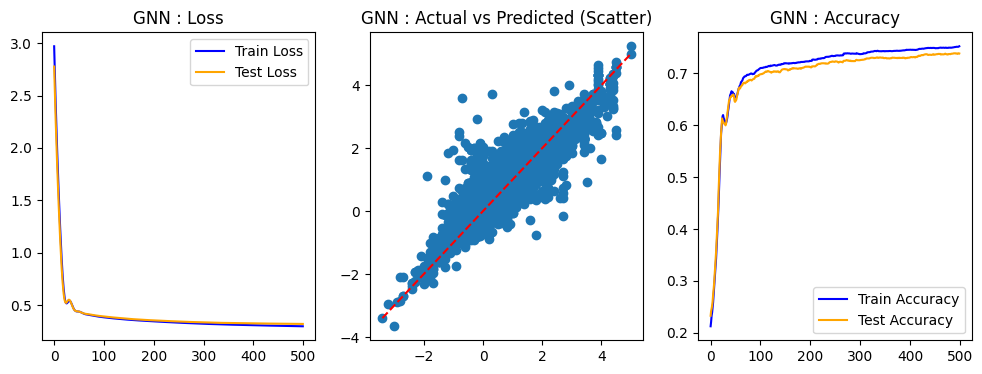

Step 3: PGM + GNN Model
Epoch 100/500, Loss: 0.3725, Accuracy: 0.7156
Epoch 200/500, Loss: 0.3338, Accuracy: 0.7344
Epoch 300/500, Loss: 0.3134, Accuracy: 0.7450
Epoch 400/500, Loss: 0.2983, Accuracy: 0.7527
Epoch 500/500, Loss: 0.2876, Accuracy: 0.7625
GNN Combined - R^2: 0.82, MSE: 0.31, Accuracy: 0.75


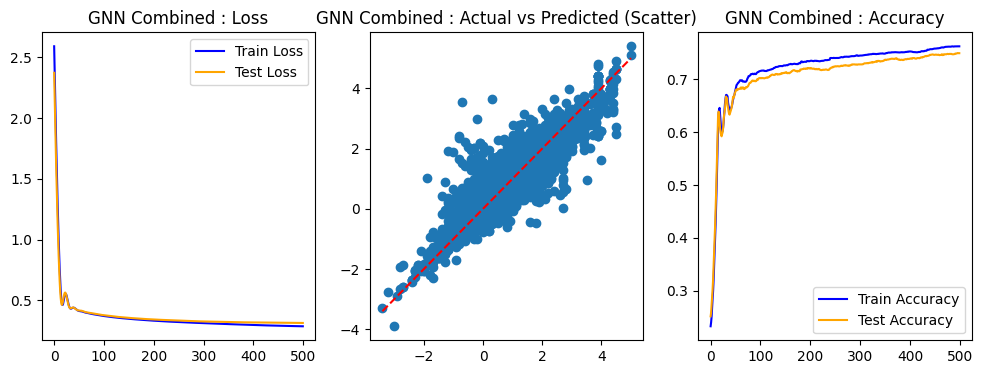

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import PandasTools

# Load the logp_synthetic data
data = pd.read_csv('logP_synthetic_dataset.csv', header=None, names=['SMILES', 'logP'])

# Function to compute molecular descriptors from SMILES
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(1)  # return a zero vector if SMILES is invalid
    descriptors = [
        Descriptors.MolWt(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.MolLogP(mol)  # LogP of the molecule
    ]
    return descriptors

# Apply descriptor computation to the SMILES column
X = np.array([compute_descriptors(smiles) for smiles in data['SMILES']])

# The target variable (logP)
y = data['logP'].values

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define an accuracy threshold for regression
accuracy_threshold = 0.5

# Function to plot results
def plot_results(model_name, y_test, preds, train_losses, test_losses, train_accuracies, test_accuracies, title_suffix=""):
    plt.figure(figsize=(12, 4))

    # Loss Graph (train vs test)
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss", color='blue')
    plt.plot(test_losses, label="Test Loss", color='orange')
    plt.title(f"{model_name} {title_suffix}: Loss")
    plt.legend()

    # Actual vs Predicted Scatter
    plt.subplot(1, 3, 2)
    plt.scatter(y_test, preds)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.title(f"{model_name} {title_suffix}: Actual vs Predicted (Scatter)")

    # Accuracy Graph (train vs test)
    plt.subplot(1, 3, 3)
    plt.plot(train_accuracies, label="Train Accuracy", color='blue')
    plt.plot(test_accuracies, label="Test Accuracy", color='orange')
    plt.title(f"{model_name} {title_suffix}: Accuracy")
    plt.legend()

    plt.show()

### Step 1: PGM Model ###
print("Step 1: PGM Model")
pgm_model = BayesianRidge()
pgm_model.fit(X_train, y_train)
pgm_preds = pgm_model.predict(X_test)

# Evaluate the performance of the PGM model
pgm_r2 = r2_score(y_test, pgm_preds)
pgm_mse = mean_squared_error(y_test, pgm_preds)
pgm_accuracy = np.mean(np.abs(pgm_preds - y_test) < accuracy_threshold)  # Accuracy based on a threshold
print(f"PGM - R^2: {pgm_r2:.2f}, MSE: {pgm_mse:.2f}, Accuracy: {pgm_accuracy:.2f}")

# Plot results for PGM
plot_results("PGM", y_test, pgm_preds, [pgm_mse] * len(y_test), [pgm_mse] * len(y_test), [pgm_accuracy] * len(y_test), [pgm_accuracy] * len(y_test))

### Step 2: GNN Model ###
print("Step 2: GNN Model")

# Define the GNN model
class GNN(nn.Module):
    def __init__(self, input_dim):
        super(GNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Convert data to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Initialize the GNN model
gnn_model = GNN(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)

# Train the GNN model
epochs = 500
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    gnn_model.train()
    optimizer.zero_grad()
    predictions = gnn_model(X_train_t)
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Calculate accuracy during training
    train_accuracy = np.mean(np.abs(predictions.detach().numpy().flatten() - y_train_t.numpy().flatten()) < accuracy_threshold)
    train_accuracies.append(train_accuracy)

    # Calculate accuracy and loss on the test dataset
    gnn_model.eval()
    with torch.no_grad():
        test_preds = gnn_model(X_test_t)
        test_loss = criterion(test_preds, y_test_t)
        test_accuracy = np.mean(np.abs(test_preds.detach().numpy().flatten() - y_test_t.numpy().flatten()) < accuracy_threshold)

    test_losses.append(test_loss.item())
    test_accuracies.append(test_accuracy)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}")

# Evaluate the GNN model
gnn_model.eval()
gnn_preds = gnn_model(X_test_t).detach().numpy().flatten()
gnn_r2 = r2_score(y_test, gnn_preds)
gnn_mse = mean_squared_error(y_test, gnn_preds)
gnn_accuracy = np.mean(np.abs(gnn_preds - y_test) < accuracy_threshold)
print(f"GNN - R^2: {gnn_r2:.2f}, MSE: {gnn_mse:.2f}, Accuracy: {gnn_accuracy:.2f}")

# Plot results for GNN
plot_results("GNN", y_test, gnn_preds, train_losses, test_losses, train_accuracies, test_accuracies)

### Step 3: PGM+GNN Model (Combination) ###
print("Step 3: PGM + GNN Model")

# Use PGM model predictions as additional input features for the GNN
pgm_preds_train = pgm_model.predict(X_train)
pgm_preds_test = pgm_model.predict(X_test)

# Add PGM predictions as a new feature
X_train_combined = np.column_stack([X_train, pgm_preds_train])
X_test_combined = np.column_stack([X_test, pgm_preds_test])

# Convert to PyTorch tensors
X_train_combined_t = torch.tensor(X_train_combined, dtype=torch.float32)
X_test_combined_t = torch.tensor(X_test_combined, dtype=torch.float32)

# Define a combined GNN model
gnn_combined_model = GNN(input_dim=X_train_combined.shape[1])
optimizer = torch.optim.Adam(gnn_combined_model.parameters(), lr=0.001)

# Train the combined model
combined_train_losses = []
combined_test_losses = []
combined_train_accuracies = []
combined_test_accuracies = []

for epoch in range(epochs):
    gnn_combined_model.train()
    optimizer.zero_grad()
    predictions = gnn_combined_model(X_train_combined_t)
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    combined_train_losses.append(loss.item())

    # Calculate accuracy during training
    train_accuracy = np.mean(np.abs(predictions.detach().numpy().flatten() - y_train_t.numpy().flatten()) < accuracy_threshold)
    combined_train_accuracies.append(train_accuracy)

    # Calculate accuracy and loss on the test dataset
    gnn_combined_model.eval()
    with torch.no_grad():
        test_preds = gnn_combined_model(X_test_combined_t)
        test_loss = criterion(test_preds, y_test_t)
        test_accuracy = np.mean(np.abs(test_preds.detach().numpy().flatten() - y_test_t.numpy().flatten()) < accuracy_threshold)

    combined_test_losses.append(test_loss.item())
    combined_test_accuracies.append(test_accuracy)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}")

# Evaluate the combined GNN model
gnn_combined_model.eval()
gnn_combined_preds = gnn_combined_model(X_test_combined_t).detach().numpy().flatten()
gnn_combined_r2 = r2_score(y_test, gnn_combined_preds)
gnn_combined_mse = mean_squared_error(y_test, gnn_combined_preds)
gnn_combined_accuracy = np.mean(np.abs(gnn_combined_preds - y_test) < accuracy_threshold)
print(f"GNN Combined - R^2: {gnn_combined_r2:.2f}, MSE: {gnn_combined_mse:.2f}, Accuracy: {gnn_combined_accuracy:.2f}")

# Plot results for combined model
plot_results("GNN Combined", y_test, gnn_combined_preds, combined_train_losses, combined_test_losses, combined_train_accuracies, combined_test_accuracies)



=== 95% Bootstrap CIs on Test Set ===
     Model  R2_mean   R2_lo   R2_hi  MSE_mean  MSE_lo  MSE_hi  ACC_mean  \
0      GNN   0.8137  0.7923  0.8330    0.3193  0.2877  0.3523    0.7373   
1  GNN+PGM   0.8166  0.7964  0.8352    0.3147  0.2834  0.3480    0.7496   
2      PGM   0.7183  0.6940  0.7402    0.4843  0.4468  0.5247    0.6458   

   ACC_lo  ACC_hi  
0  0.7214  0.7543  
1  0.7334  0.7649  
2  0.6277  0.6643  


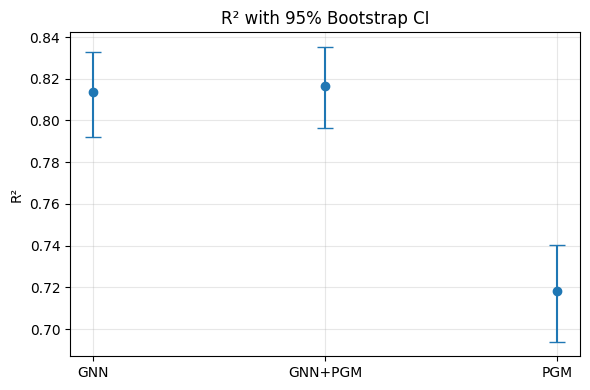

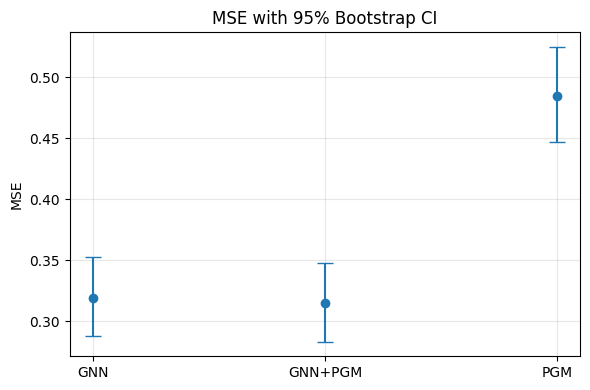

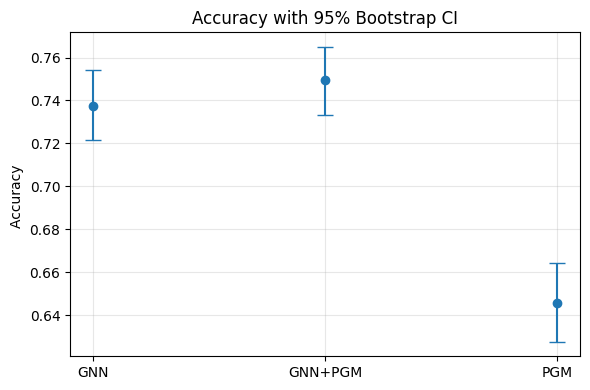

In [24]:
# ==== 95% CIs (bootstrap on test set) + Error-bar plots per metric ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# Reuse: y_test (Series), accuracy_threshold (float),
# and predictions: pgm_preds, gnn_preds, gnn_combined_preds

rng = np.random.default_rng(42)

y_true = np.asarray(y_test, dtype=float)
preds_dict = {
    "PGM": np.asarray(pgm_preds, dtype=float).flatten(),
    "GNN": np.asarray(gnn_preds, dtype=float).flatten(),
    "GNN+PGM": np.asarray(gnn_combined_preds, dtype=float).flatten(),
}

def acc_within(y, p, thr):
    return np.mean(np.abs(p - y) < thr)

def r2_safe(y, p):
    # Avoid undefined R² if y is (near) constant in a bootstrap resample
    if np.allclose(y, y.mean()):
        return 0.0
    return r2_score(y, p)

def bootstrap_metric(y, p, metric_fn, n_boot=2000, rng=None):
    """Percentile bootstrap 95% CI for a scalar metric on paired data."""
    n = len(y)
    idx = np.arange(n)
    stats = np.empty(n_boot, dtype=float)
    for b in range(n_boot):
        res = rng.choice(idx, size=n, replace=True)
        stats[b] = metric_fn(y[res], p[res])
    stats.sort()
    lo = np.percentile(stats, 2.5)
    hi = np.percentile(stats, 97.5)
    mean = float(stats.mean())
    return mean, lo, hi

rows = []
for name, p in preds_dict.items():
    r2_mean, r2_lo, r2_hi = bootstrap_metric(y_true, p, r2_safe, n_boot=2000, rng=rng)
    mse_mean, mse_lo, mse_hi = bootstrap_metric(y_true, p, mean_squared_error, n_boot=2000, rng=rng)
    acc_mean, acc_lo, acc_hi = bootstrap_metric(
        y_true, p, lambda y, q: acc_within(y, q, accuracy_threshold), n_boot=2000, rng=rng
    )
    rows.append({
        "Model": name,
        "R2_mean": r2_mean, "R2_lo": r2_lo, "R2_hi": r2_hi,
        "MSE_mean": mse_mean, "MSE_lo": mse_lo, "MSE_hi": mse_hi,
        "ACC_mean": acc_mean, "ACC_lo": acc_lo, "ACC_hi": acc_hi,
    })

summary_df = pd.DataFrame(rows).sort_values("Model").reset_index(drop=True)
print("\n=== 95% Bootstrap CIs on Test Set ===")
print(summary_df[[
    "Model",
    "R2_mean","R2_lo","R2_hi",
    "MSE_mean","MSE_lo","MSE_hi",
    "ACC_mean","ACC_lo","ACC_hi"
]].round(4))

# --- Error-bar plots (asymmetric) ---
def errorbar_plot(metric, ylabel, title):
    labels = summary_df["Model"].values
    means = summary_df[f"{metric}_mean"].values
    los   = summary_df[f"{metric}_lo"].values
    his   = summary_df[f"{metric}_hi"].values
    yerr  = np.vstack([means - los, his - means])  # asymmetric
    x = np.arange(len(labels))
    plt.figure(figsize=(6,4))
    plt.errorbar(x, means, yerr=yerr, fmt='o', capsize=6)
    plt.xticks(x, labels)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

errorbar_plot("R2",  "R²",  "R² with 95% Bootstrap CI")
errorbar_plot("MSE", "MSE", "MSE with 95% Bootstrap CI")
errorbar_plot("ACC", f'Accuracy ', "Accuracy with 95% Bootstrap CI")
# ==== End CI block ====
